# California Housing - Decision Tree Regressor


In [1]:
# Load 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Fetch dataset
data = fetch_california_housing()
X = data.data
y = data.target  # median house value (in $100,000s)
feature_names = data.feature_names

print(X.shape, y.shape)
print(feature_names)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_base.py:1519: UserWarning: Retry downloading from url: https://ndownloader.figshare.com/files/5976036
  warnings.warn(f"Retry downloading from url: {remote.url}")


(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# metrics function
def regression_metrics(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    return rmse, mae, r2

# Baseline: Linear Regression


In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
regression_metrics(y_test, y_pred_lr, "Linear Regression")

Linear Regression -> RMSE: 0.7456, MAE: 0.5332, R2: 0.5758


(0.7455813830127749, 0.5332001304956976, 0.5757877060324524)

# Decision Tree Regressor


In [6]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
regression_metrics(y_test, y_pred_tree, "Decision Tree (no limits)")

Decision Tree (no limits) -> RMSE: 0.7069, MAE: 0.4558, R2: 0.6187


(0.7068996727915191, 0.4557622892441861, 0.6186632145457622)

# Tune max_depth (reduce overfitting)


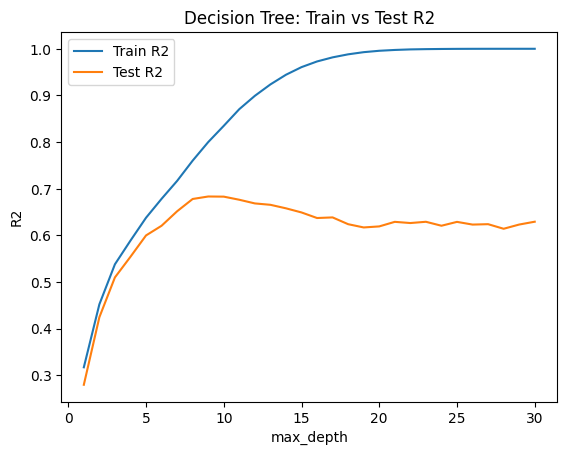

Best depth: 9


In [7]:
depths = range(1, 31)
train_r2 = []
test_r2 = []

for d in depths:
    m = DecisionTreeRegressor(max_depth=d, random_state=42)
    m.fit(X_train, y_train)
    train_r2.append(m.score(X_train, y_train))
    test_r2.append(m.score(X_test, y_test))

plt.figure()
plt.plot(depths, train_r2, label="Train R2")
plt.plot(depths, test_r2, label="Test R2")
plt.xlabel("max_depth")
plt.ylabel("R2")
plt.title("Decision Tree: Train vs Test R2")
plt.legend()
plt.show()

best_depth = depths[int(np.argmax(test_r2))]
print("Best depth:", best_depth)

In [8]:
tree_best = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_best.fit(X_train, y_train)

y_pred_best = tree_best.predict(X_test)
regression_metrics(y_test, y_pred_best, f"Decision Tree (max_depth={best_depth})")

Decision Tree (max_depth=9) -> RMSE: 0.6443, MAE: 0.4357, R2: 0.6833


(0.6442578164688181, 0.43568046661955595, 0.6832529836308363)

# Cost-complexity pruning (ccp_alpha)


In [9]:
path = DecisionTreeRegressor(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# try a subset to keep it fast
alphas = ccp_alphas[::max(1, len(ccp_alphas)//50)]

best_alpha, best_r2 = None, -1
for a in alphas:
    m = DecisionTreeRegressor(random_state=42, ccp_alpha=a)
    m.fit(X_train, y_train)
    r2 = m.score(X_test, y_test)
    if r2 > best_r2:
        best_r2, best_alpha = r2, a

print("Best ccp_alpha:", best_alpha, "Test R2:", best_r2)

tree_pruned = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
tree_pruned.fit(X_train, y_train)
regression_metrics(y_test, tree_pruned.predict(X_test), f"Pruned Tree (alpha={best_alpha:.6f})")

Best ccp_alpha: 0.0002488656007512667 Test R2: 0.6958942418081432
Pruned Tree (alpha=0.000249) -> RMSE: 0.6313, MAE: 0.4175, R2: 0.6959


(0.6312708736108179, 0.4174542136290493, 0.6958942418081432)

# Feature importance + partial dependence plots


Key interpretation tips (ML Engineer style)
• Impurity importance: “Which features the tree used a lot to reduce error.”
• Permutation importance: “Which features truly matter for predictive performance.”
• PDP: “How the prediction changes as a feature increases (on average).”
• ICE: “Whether that effect is consistent across samples.”


In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeRegressor(max_depth=8, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

# Impurity-based importance (fast, built-in)


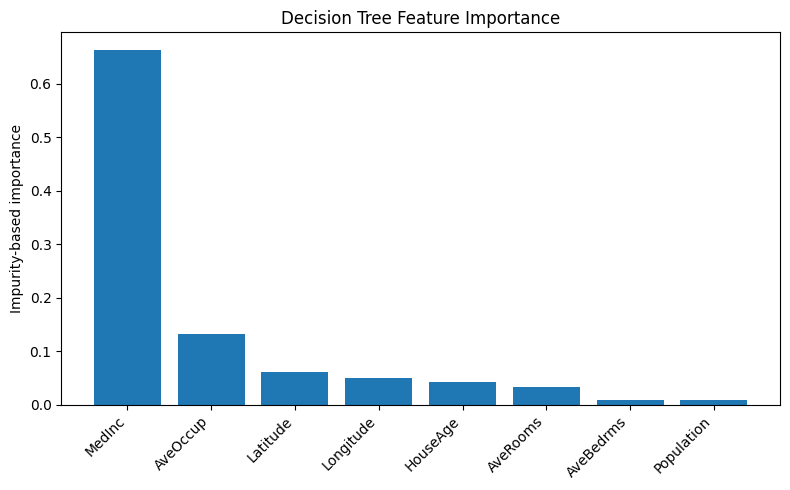

In [11]:
import numpy as np
import matplotlib.pyplot as plt

imp = tree.feature_importances_
order = np.argsort(imp)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(imp)), imp[order])
plt.xticks(range(len(imp)), [feature_names[i] for i in order], rotation=45, ha="right")
plt.ylabel("Impurity-based importance")
plt.title("Decision Tree Feature Importance")
plt.tight_layout()
plt.show()

# Permutation importance (more reliable)


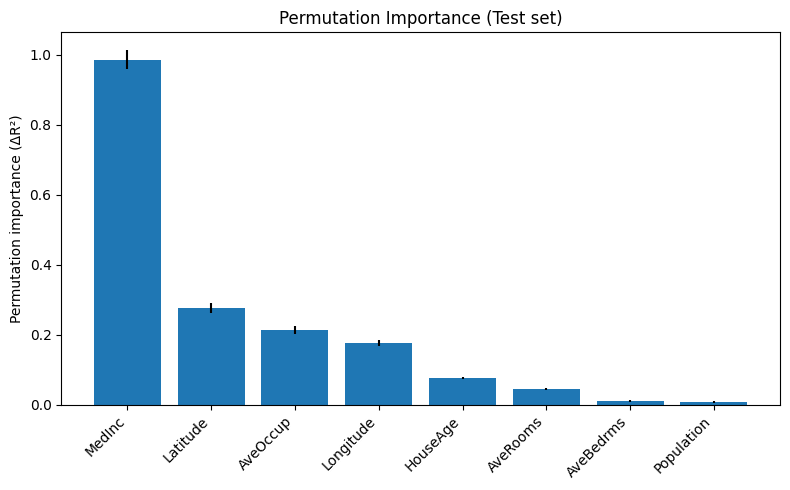

In [12]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    tree, X_test, y_test,
    n_repeats=10, random_state=42, scoring="r2"
)

perm_imp = r.importances_mean
perm_std = r.importances_std
order = np.argsort(perm_imp)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(perm_imp)), perm_imp[order], yerr=perm_std[order])
plt.xticks(range(len(perm_imp)), [feature_names[i] for i in order], rotation=45, ha="right")
plt.ylabel("Permutation importance (ΔR²)")
plt.title("Permutation Importance (Test set)")
plt.tight_layout()
plt.show()

# Partial Dependence Plots


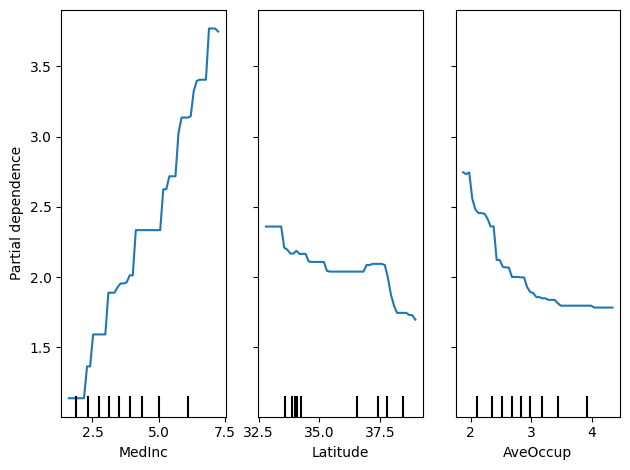

In [13]:
#PDP for top 2–3 important features
from sklearn.inspection import PartialDependenceDisplay

top_features = [feature_names[i] for i in order[:3]]
top_idx = [feature_names.index(f) for f in top_features]

PartialDependenceDisplay.from_estimator(
    tree, X_test, top_idx,
    feature_names=feature_names,
    kind="average",  # PDP
    grid_resolution=50
)
plt.tight_layout()
plt.show()

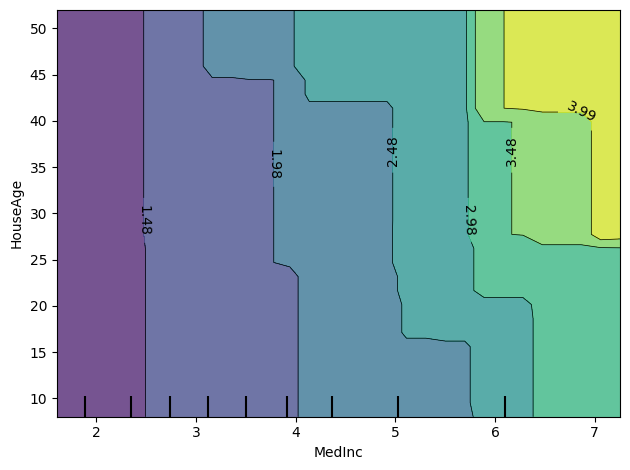

In [16]:
# 2D PDP interaction (very useful)
PartialDependenceDisplay.from_estimator(
    tree, X_test, [(0, 1)],  # example feature indices
    feature_names=feature_names,
    grid_resolution=30
)
plt.tight_layout()
plt.show()

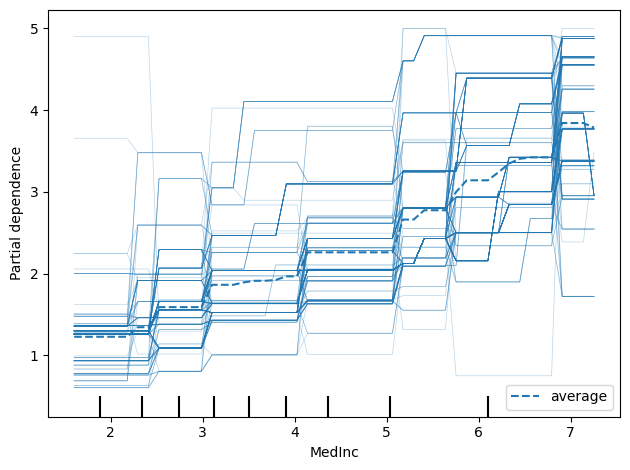

In [17]:
# ICE curves
PartialDependenceDisplay.from_estimator(
    tree, X_test, [top_idx[0]],
    feature_names=feature_names,
    kind="both",   # PDP + ICE
    subsample=200, # keeps plot readable
    grid_resolution=50
)
plt.tight_layout()
plt.show()